# Stpe42, 선형회귀

## 42.1 토이 데이터셋 

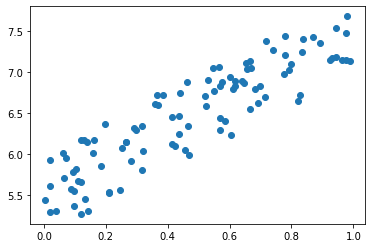

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

np.random.seed(0)   # 시드값 고정 
x = np.random.rand(100,1)
y = 5 + 2*x + np.random.rand(100,1)

plt.scatter(x,y)
plt.show()


## 42.2 선형 회귀 이론

데이터와 예측치의 차이, 즉 잔차(residual)을 최소화해야한다.

## 42.3 선형 회귀 구현 

In [2]:
import numpy as np 
from dezero import Variable
import dezero.functions as F 

# 토이 데이터셋 
np.random.seed(0)
x = np.random.rand(100,1)
y = 5 + 2*x + np.random.rand(100,1)
x,y = Variable(x), Variable(y)

W = Variable(np.zeros((1,1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x,W) + b 
    return y 

In [3]:
def mean_squared_error(x0, x1):
    diff = x0 - x1 
    return F.sum(diff**2) / len(diff)

lr = 0.1 
iters = 100 

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    # 업데이트
    W.data -= lr * W.grad.data 
    b.data -= lr * b.grad.data 
    print(W,b,loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.5542803813535926)
variable([[2.21482401]]) variable([4.52705574]) variable(1.4925998690471942)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756932)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227453)
variable([[2.39573972]]) variable([4.9467725]) variable(0.35859153083192785)
variable([[2.425382]]) variable([5.02561369]) variable(0.2491573197756112)
variable([[2.44575118]]) variable([5.08588371]) variable(0.18690658765397886)
variable([[2.45917205]]) variable([5.13217364]) variable(0.15135336296314875)
varia

In [4]:
print(W)
print(b)

variable([[2.11807369]])
variable([5.46608905])


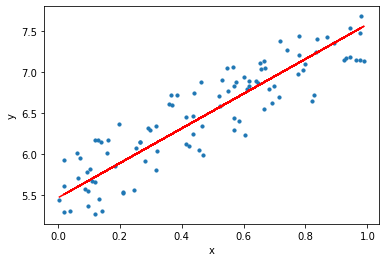

In [5]:
# Plot
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
y_pred = predict(x)
plt.plot(x.data, y_pred.data, color='r')
plt.show()

## 42.2 \[보충\] DeZero의 mean_squared_error 함수

방금 구현한 평균 제곱 오차를 구하는 함수

~~~python 
def mean_squared_error(x0, x1):
    diff = x0 - x1 
    return F.sum(diff**2) / len(diff)
~~~

이 함수는 계산을 정확하게 수행한다.  
하지만 개선할 점이 있다.

위 함수가 순전파를 진행하는동안 중간 중간에 이름 없는 변수가 세개 등장한다.  
이 변수들은 계산 그래프에 기록되어 있기 때문에 계산 그래프가 존재하는 동안은 메모리에 계속 살아 있다.  
이 변수들의 데이터도 마찬가지로 계속 살아 있다.

Function 클래스를 상속하여 구현하는 방식으로 메모리를 점더 아낀다.

In [6]:
from dezero import Function

# functions.py
def mean_squared_error_simple(x0, x1):
    x0, x1 = as_variable(x0), as_variable(x1)
    diff = x0 - x1
    y = sum(diff ** 2) / len(diff)
    return y


class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1


def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)

In [7]:
# functions.py 
from dezero import Function

class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W)
        if b is not None:
            y += b
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb


def linear(x, W, b=None):
    return Linear()(x, W, b)


def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t

    y = t + b
    t.data = None  # Release t.data (ndarray) for memory efficiency
    return y